# Notebook GUI for finding parameters for binary conversion

In [1]:
%matplotlib notebook
# %matplotlib inline
from IPython.display import clear_output

import sys
import os
import numpy as np
import pandas as pd
import glob
import h5py
import time


from scipy.ndimage.filters import median_filter
from ImageStackPy import Img_Viewer as VIEW

import matplotlib.pyplot as plt
import matplotlib as mpl
import tifffile as tiff


from ct_segnet import viewer


from ImageStackPy import ImageProcessing as IP

from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display, update_display
from ipyfilechooser import FileChooser
from skimage.io import imread

import cv2, os, h5py, collections, sys, math
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output
from ipywidgets import interactive
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure,measurements,morphology 
from scipy.ndimage import binary_erosion, binary_dilation
from skimage import data
from skimage.filters import threshold_otsu


import sys
if '../' not in sys.path:
    sys.path.append('../')

from tools.misc.Utils import CenterSampling, ClusterAnalysis
from tools.misc.patches2d import Patches2D


def text_width(wd):
    return Layout(width = "%ipx"%wd)

Extracted cells will be at:  /data02/AZC/AI_XRF/annotated_XRF/raw_cells


<IPython.core.display.Javascript object>


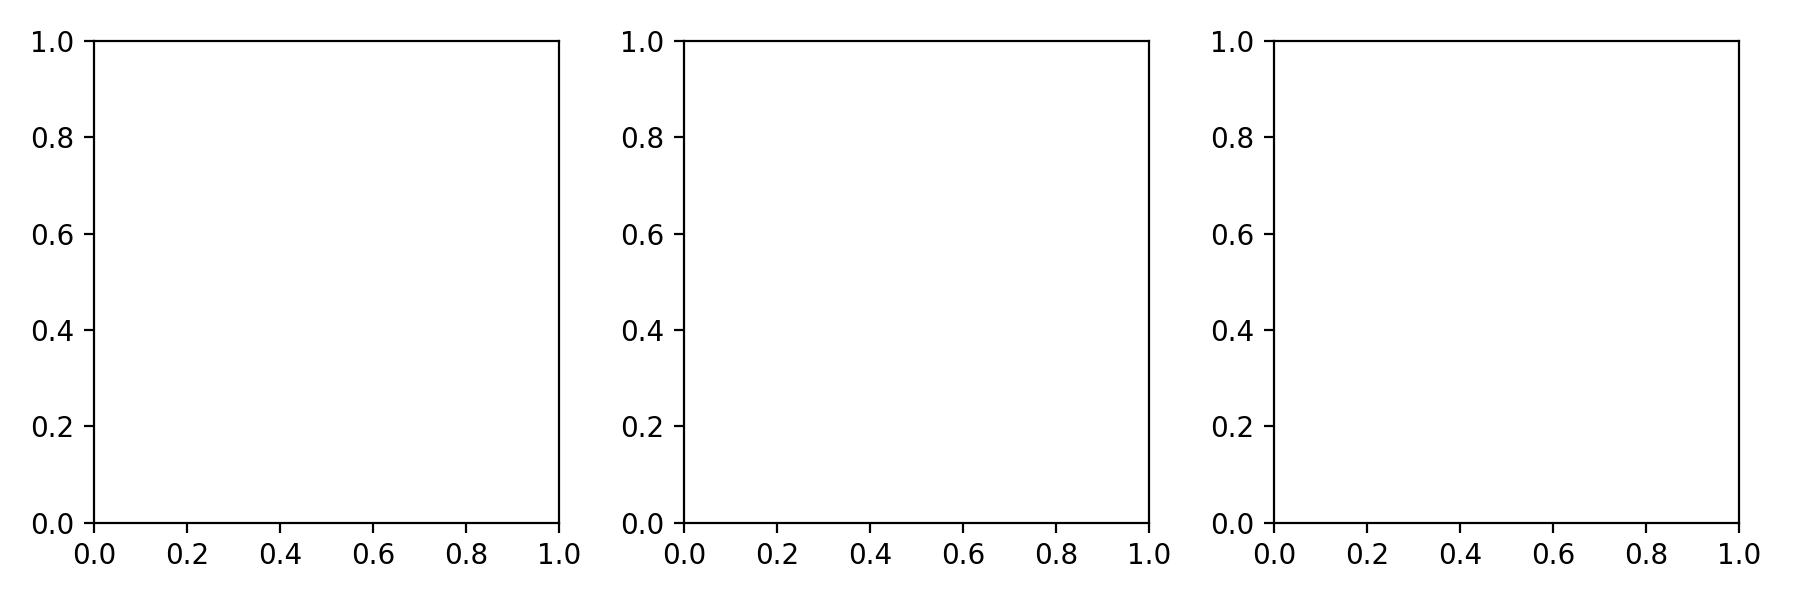

<IPython.core.display.Javascript object>


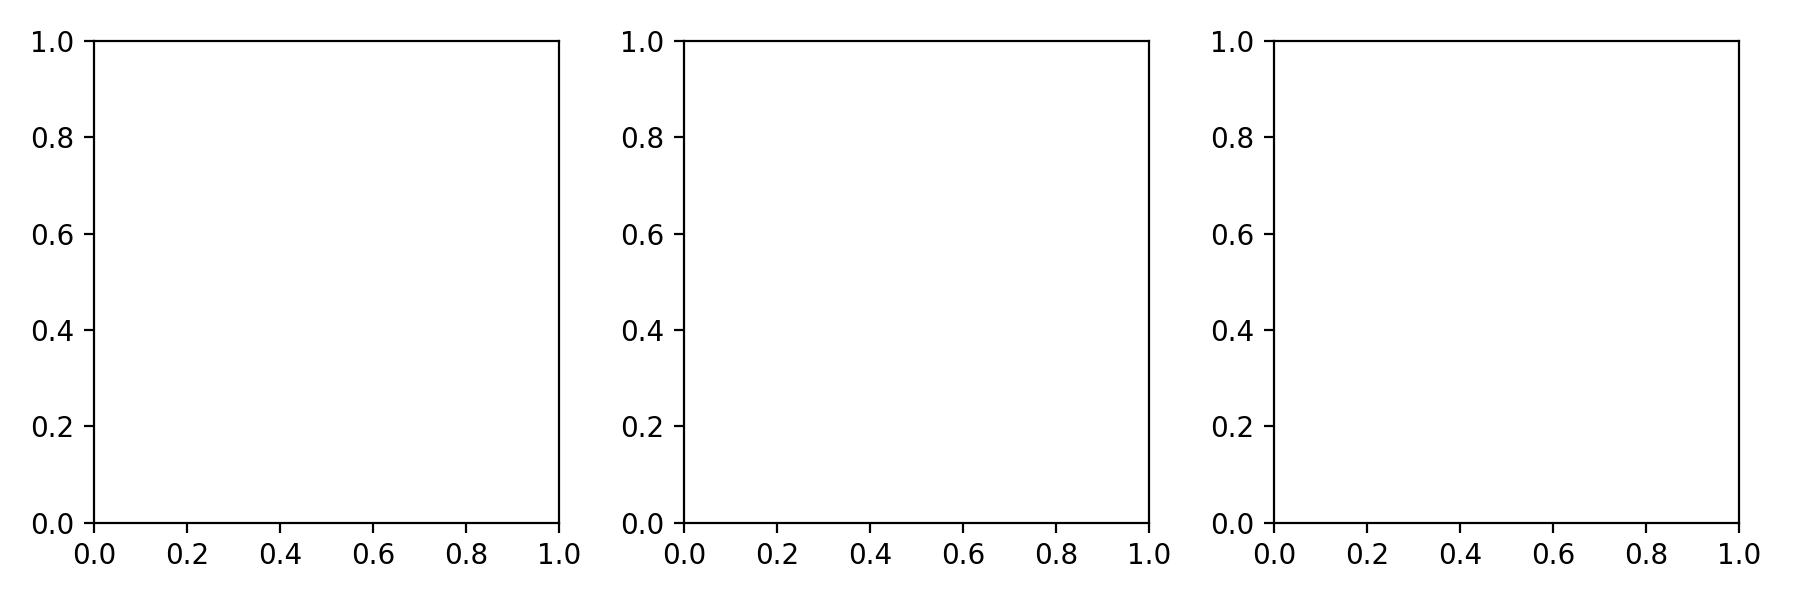

<IPython.core.display.Javascript object>


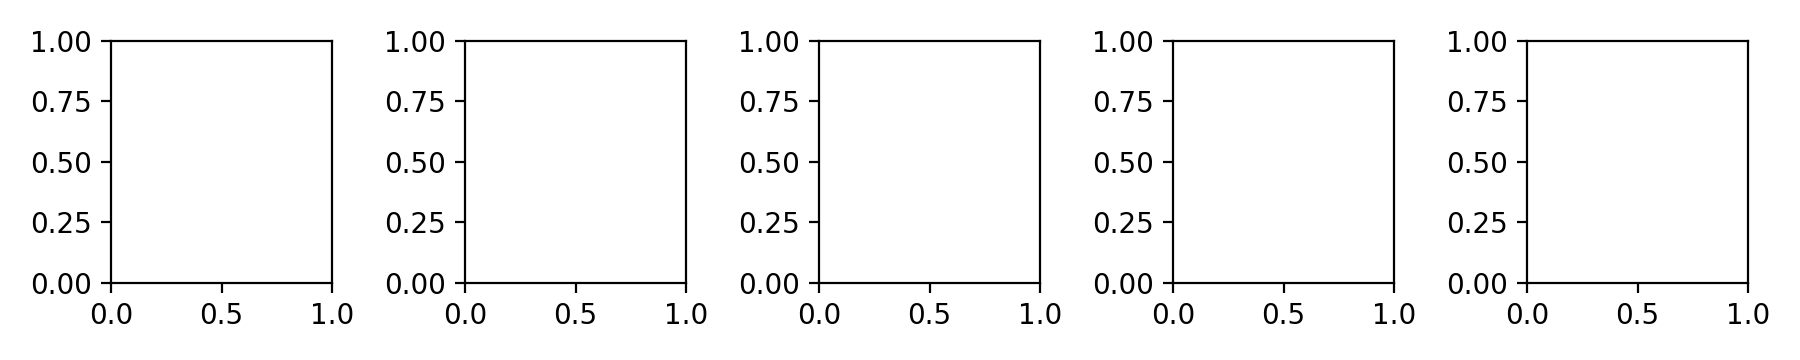

<IPython.core.display.Javascript object>


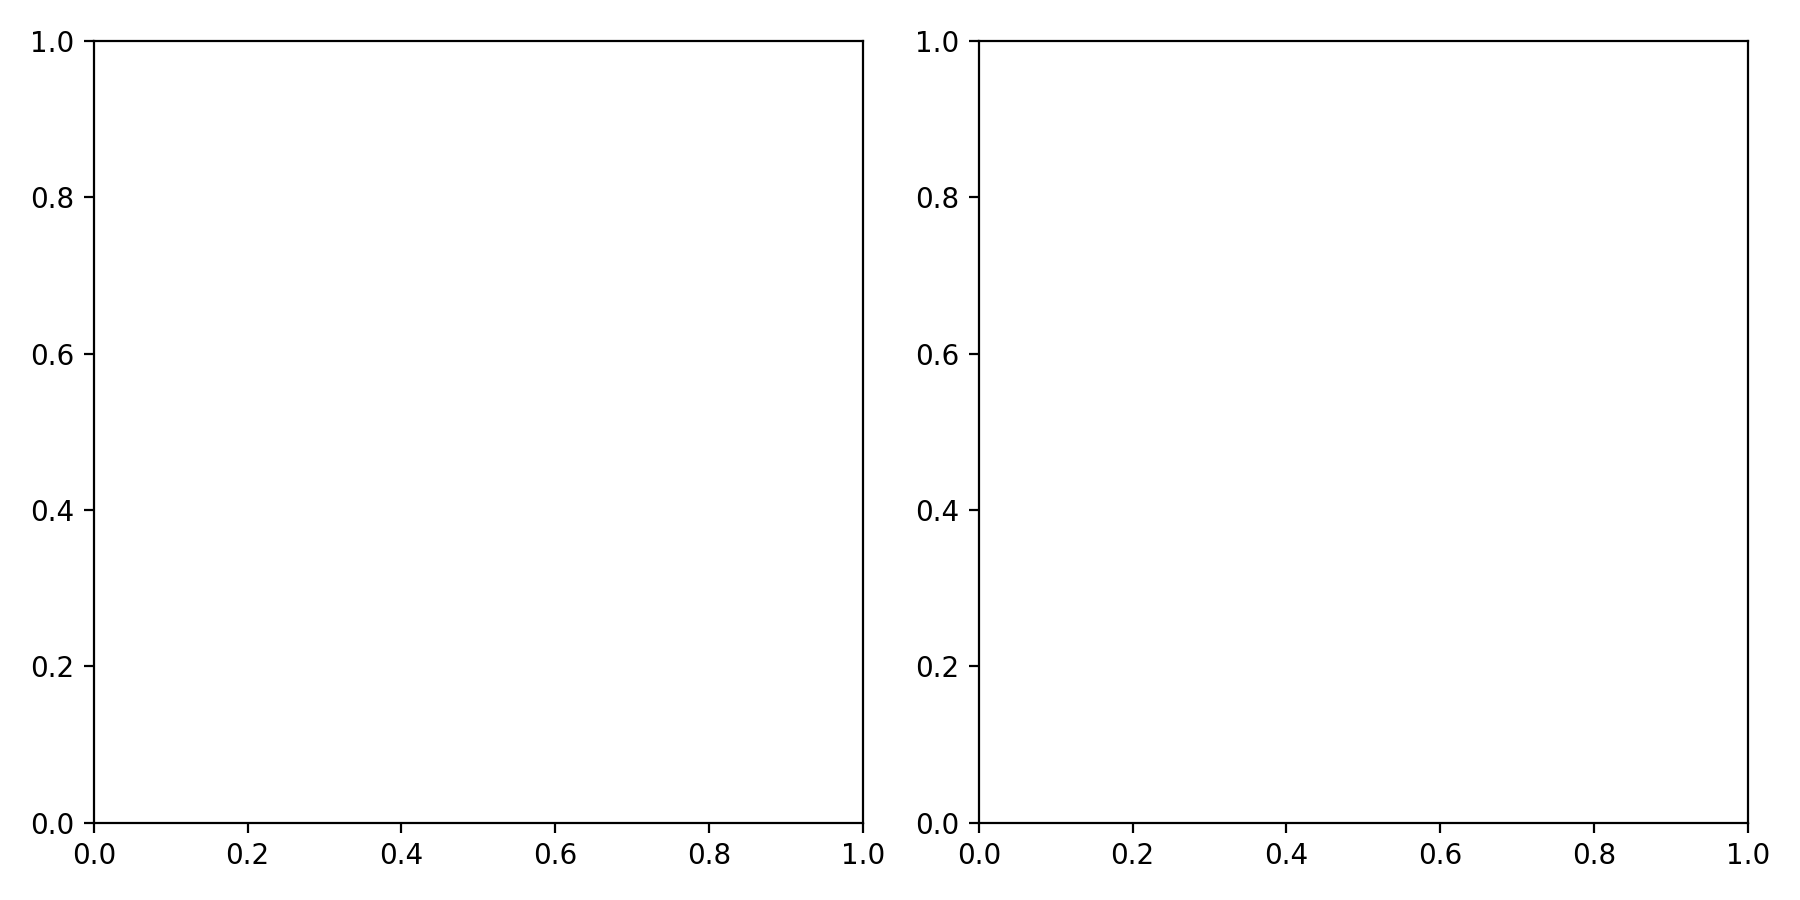

In [5]:
annot_dir='annotated_XRF'

# os.chdir('..') #go back one directory

# is_annot_dir_Exist = os.path.exists(os.path.join(os.getcwd(),annot_dir))


# if not is_annot_dir_Exist:
#     os.mkdir(annot_dir)


# is_raw_cells_dir_Exist = os.path.exists(os.path.join(os.path.join(os.getcwd(),annot_dir),'raw_cells'))

# if not is_annot_dir_Exist:
#     print('error')
#     os.mkdir(os.path.join(os.path.join(os.getcwd(),annot_dir),'raw_cells'))
                                    
#Path for saving the images of the extracted cells
# base__dir_path='/data02/AZC/annotated_XRF/raw_cells'

base__dir_path=os.path.join(os.path.join(os.path.dirname(os.getcwd()),annot_dir), 'raw_cells')
print("Extracted cells will be at: ", base__dir_path)

def load_h5(obj):
    global d_Cu, d_Zn, d_Ca, d_K, d_P, d_S
    print(fc.selected)
    norm_ch = 'us_ic'
    value_offset=1e-12
    xrfdata = collections.defaultdict(list)

    with h5py.File(fc.selected, 'r') as dat:
        groups= list(dat.keys())
        maps= list(dat['MAPS'].keys())
        chs = dat['MAPS/channel_names'][:].astype(str).tolist()
#         dat['MAPS/']
#         print(chs)
        w.options=chs
        w.disabled=False
        w1.options=groups
        w1.disabled=False
        w2.options=maps
        w2.disabled=False
        

        btn_bin.disabled=False
        w_bin_elm.disabled=False
        Md_filt_size.disabled=False
        w_bin_type.disabled=False
        
        btn_extract.disabled=False
        crop_width_text.disabled=False
    

        xrf = dat['MAPS/XRF_roi'][:]
#         print(xrf)
        
        scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
        scaler_val = dat['MAPS/scalers'][:]
        norm = scaler_val[scaler_names.index(norm_ch)]
        for e in chs:
            chidx = chs.index(e)
            xrfdata[e].append(xrf[chidx]/norm)
        xrfdata['scan_num'].append(fc.selected_filename)
        xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
        xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
    xrfdata = pd.DataFrame(xrfdata)
#     print(xrfdata)

    elms=['Cu','Zn','Ca', 'K', 'P', 'S']#Default elms
    for i, row in xrfdata.iterrows():
            sc = row['scan_num'][0:row['scan_num'].index('.')]
            for e in elms:
                d = row[e]
                
                d[np.isnan(d) | np.isinf(d)] = 0
                norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)
                if e == 'Cu':
                    d_Cu=d
                    norm_d_Cu=norm_d
                    x_Cu,y_Cu=row['x_axis'], row['y_axis']
                if e == 'Zn':
                    d_Zn=d
                    norm_d_Zn=norm_d
                    x_Zn,y_Zn=row['x_axis'], row['y_axis']
                if e == 'Ca':
                    d_Ca=d
                    norm_d_Ca=norm_d
                    x_Ca,y_Ca=row['x_axis'], row['y_axis']
                if e == 'K':
                    d_K=d
                    norm_d_K=norm_d
                    x_K,y_K=row['x_axis'], row['y_axis']
                if e == 'P':
                    d_P=d
                    norm_d_P=norm_d
                    x_P,y_P=row['x_axis'], row['y_axis']
                if e == 'S':
                    d_S=d
                    norm_d_S=norm_d
                    x_S,y_S=row['x_axis'], row['y_axis']
    print('Image shape: ',d.shape)
#     fig, ax = plt.subplots(1,3,figsize=(9,3))
#     fig.tight_layout()
    
#     ax[0].clear()
#     ax[1].clear()
#     ax[2].clear()
    img1 = ax[0].pcolormesh(x_Cu, y_Cu, d_Cu, shading = 'gouraud')
#     img1 = ax[0].imshow(d_Cu, cmap = 'viridis')
#     ax[0].colorbar()
    ax[0].axis('off')
    viewer.add_scalebar(ax[0],10,1.17)
    cbar1 = fig.colorbar(img1, location='bottom', orientation='horizontal', ax=ax[0] ,shrink=0.98)
    cbar1.ax.tick_params(labelsize=8)
    cbar1.ax.ticklabel_format(style='sci', scilimits=(-8,8))
    
    img2 = ax[1].pcolormesh(x_Zn, y_Zn, d_Zn, shading = 'gouraud')
#     img2 = ax[1].imshow(d_Zn, cmap = 'viridis')
#     ax[1].colorbar()
    ax[1].axis('off')
    viewer.add_scalebar(ax[1],10,1.17)
    cbar2 = fig.colorbar(img2, location='bottom', orientation='horizontal', ax=ax[1] ,shrink=0.98)
    cbar2.ax.tick_params(labelsize=8)
    cbar2.ax.ticklabel_format(style='sci', scilimits=(-8,8))

    img3 = ax[2].pcolormesh(x_Ca, y_Ca, d_Ca, shading = 'gouraud')
#     img3 = ax[2].imshow(d_Ca, cmap = 'viridis')
#     ax[2].colorbar()
    ax[2].axis('off')
    viewer.add_scalebar(ax[2],10,1.17)
    cbar3 = fig.colorbar(img3, location='bottom', orientation='horizontal', ax=ax[2], shrink=0.98)
    cbar3.ax.tick_params(labelsize=8)
    cbar3.ax.ticklabel_format(style='sci', scilimits=(-8,8))
#     fig.colorbar()
    ax[0].set_title('Cu')
    ax[1].set_title('Zn')
    ax[2].set_title('Ca')
    fig.canvas.draw()
#     fig.canvas.flush_events()

    fig.show()
    
    img4 = ax_row_2[0].pcolormesh(x_K, y_K, d_K, shading = 'gouraud')
    ax_row_2[0].axis('off')
    viewer.add_scalebar(ax_row_2[0],10,1.17)
    cbar4 = fig.colorbar(img4, location='bottom', orientation='horizontal', ax=ax_row_2[0] ,shrink=0.98)
    cbar4.ax.tick_params(labelsize=8)
    cbar4.ax.ticklabel_format(style='sci', scilimits=(-8,8))

    img5 = ax_row_2[1].pcolormesh(x_P, y_P, d_P, shading = 'gouraud')
    ax_row_2[1].axis('off')
    viewer.add_scalebar(ax_row_2[1],10,1.17)
    cbar5 = fig.colorbar(img5, location='bottom', orientation='horizontal', ax=ax_row_2[1] ,shrink=0.98)
    cbar5.ax.tick_params(labelsize=8)
    cbar5.ax.ticklabel_format(style='sci', scilimits=(-8,8))
    
    img6 = ax_row_2[2].pcolormesh(x_S, y_S, d_S, shading = 'gouraud')
    ax_row_2[1].axis('off')
    viewer.add_scalebar(ax_row_2[2],10,1.17)
    cbar5 = fig.colorbar(img5, location='bottom', orientation='horizontal', ax=ax_row_2[2] ,shrink=0.98)
    cbar5.ax.tick_params(labelsize=8)
    cbar5.ax.ticklabel_format(style='sci', scilimits=(-8,8))

    ax_row_2[0].set_title('K')
    ax_row_2[1].set_title('P')
    ax_row_2[2].set_title('S')


        
                
                
#                 tiff.imsave('%s/%s_%s_ss_%.2f.tiff'%(outpath, sc, e, ss), d)
#                 tiff.imsave('%s/%s_%s_norm_ss_%.2f.tiff'%(outpath, sc, e, ss), norm_d)
#                 pltPlot=True
#                 colorbar=True
#                 if pltPlot:
#                     fig, ax = plt.subplots(1,2,figsize=(5,3))
#                     img1 = ax[0].pcolormesh(row['x_axis'], row['y_axis'], d, shading = 'gouraud')
#                     img2 = ax[1].pcolormesh(row['x_axis'], row['y_axis'], norm_d, vmin = 0, vmax = 1, shading = 'gouraud')
#                     ax[0].set_title(e)
#                     ax[1].set_title(e + '_norm')

#                     if colorbar:
#                         for i, img_str in enumerate(['img1', 'img2']):
#                             img = eval(img_str)
#                             divider = make_axes_locatable(ax[i])
#                             cax = divider.append_axes("right", size="2%", pad=0.05)
#                             cbar = fig.colorbar(img, cax = cax, shrink=0.8)
#                             cbar.ax.tick_params(labelsize=5)
#                     plt.tight_layout()
#     dat.close()

  
def convert_to_bin(obj):
    global data,binary_ero_dil,masked_data
    
    if w_bin_type.value=='Erosion-Dilation':
        if w_bin_elm.value=='Cu':
            data = d_Cu
        elif w_bin_elm.value=='Zn':
            data = d_Zn
        elif w_bin_elm.value=='Ca':
            data = d_Ca
        elif w_bin_elm.value=='K':
            data = d_K
        elif w_bin_elm.value=='P':
            data = d_P
        elif w_bin_elm.value=='S':
            data = d_S
        

        data_original=data

        data = ndimage.median_filter(data, size=Md_filt_size.value)


        thresh = threshold_otsu(data)
        binary = data < thresh
        binary = binary^1


        binary_eroded=ndimage.binary_erosion(binary).astype(binary.dtype)
        binary_dilated=ndimage.binary_dilation(binary).astype(binary.dtype)
        binary_ero_dil=ndimage.binary_dilation(binary_eroded).astype(binary_eroded.dtype)

        print('Erosion-Dilation Processing...')
        print('Conversion channel: ', w_bin_elm.value)
        

        ax_ero_dil_process[0].imshow(data)
        ax_ero_dil_process[0].set_title('Original')
        ax_ero_dil_process[0].axis('off')

        ax_ero_dil_process[1].imshow(binary, cmap=plt.cm.gray)
        ax_ero_dil_process[1].set_title('Thresholded Image')
        ax_ero_dil_process[1].axis('off')

        ax_ero_dil_process[2].imshow(binary_eroded, cmap=plt.cm.gray)
        ax_ero_dil_process[2].set_title('Eroded Image')
        ax_ero_dil_process[2].axis('off')

        ax_ero_dil_process[3].imshow(binary_dilated, cmap=plt.cm.gray)
        ax_ero_dil_process[3].set_title('Dilated Image')
        ax_ero_dil_process[3].axis('off')

        ax_ero_dil_process[4].imshow(binary_ero_dil, cmap=plt.cm.gray)
        ax_ero_dil_process[4].set_title('Eroded-Dilated Image')
        ax_ero_dil_process[4].axis('off')



        plt.show()


        #Assign ndimage labels

        labeled_array, num_features = label(binary_ero_dil)


        print('Number of components (cells) identified: ',num_features)

        
        ax_orig_convt[0].imshow(data);
        ax_orig_convt[0].set_title('Original');
        ax_orig_convt[0].axis('off');

        ax_orig_convt[1].imshow(binary_ero_dil, cmap=plt.cm.gray);
        ax_orig_convt[1].set_title('Eroded-Dilated Image');
        ax_orig_convt[1].axis('off');
        
    elif w_bin_type.value=='k-means':
        if w_bin_elm.value=='Cu':
            data = d_Cu
        elif w_bin_elm.value=='Zn':
            data = d_Zn
        elif w_bin_elm.value=='Ca':
            data = d_Ca
        elif w_bin_elm.value=='K':
            data = d_K
        elif w_bin_elm.value=='P':
            data = d_P
        elif w_bin_elm.value=='S':
            data = d_S
        
        
        print('k-means Processing...')
        print('Conversion channel: ', w_bin_elm.value)
        
        n_clusters = 2
        random_state = 52
        k = ClusterAnalysis.kmean_analysis(n_clusters, 
                       data, 
                       random_state, 
                       sigma = None, 
                       cval = None, 
                       plotoption = False, 
                       savefig = None, 
                       fname = None, 
                       figsize=(15,4))

        # since no blue is apply, prepare modify figure and save mask
        mask = k[2]
        masked_data = data * k[2]
        d_str = ['data', 'mask', 'masked_data']
        color = ['gray', 'inferno', 'gray']
        fig, ax = plt.subplots(1,3,figsize=(15,4))
        for s_, ax_, c_ in zip(d_str, ax, color):
            img = ax_.imshow(eval(s_), cmap = c_)
            cbar = fig.colorbar(img, ax = ax_, shrink = 0.8)
            ax_.set_xticks([])
            ax_.set_yticks([])
            ax_.set_title(s_)
        plt.tight_layout()


def extract_cells(obj):
    global BASE_PATCH_WIDTH,Patches
    BASE_PATCH_WIDTH=crop_width_text.value
    if w_bin_type.value=='Erosion-Dilation':    
        print('Erosion-Dilation extraction')
        y_corner_cells, x_corner_cells, y_centers_cells, x_centers_cells = CenterSampling(BASE_PATCH_WIDTH).get_cell_centers(data, 
                                                          binary_ero_dil
                                                          )

        mini_patch_size=(BASE_PATCH_WIDTH,BASE_PATCH_WIDTH)
        print(mini_patch_size)

        widths=np.array([mini_patch_size]*len(x_centers_cells))

        points=np.array([y_corner_cells,x_corner_cells]).T.astype(int)

        p = Patches2D(data.shape, \
                      points=points, \
                      widths=widths, \
                      initialize_by = "data", 
                      )

        Patches = p.extract(data, mini_patch_size)
        print('No. of patches = ', Patches.shape[0])
        
    elif w_bin_type.value=='k-means':
        print('k-means extraction')
        y_corner_cells, x_corner_cells, y_centers_cells, x_centers_cells = CenterSampling(BASE_PATCH_WIDTH).get_cell_centers(data, 
                                                          masked_data
                                                          )

        mini_patch_size=(BASE_PATCH_WIDTH,BASE_PATCH_WIDTH)
        print(mini_patch_size)

        widths=np.array([mini_patch_size]*len(x_centers_cells))

        points=np.array([y_corner_cells,x_corner_cells]).T.astype(int)

        p = Patches2D(data.shape, \
                      points=points, \
                      widths=widths, \
                      initialize_by = "data", 
                      )

        Patches = p.extract(data, mini_patch_size)
        print('No. of patches = ', Patches.shape[0])
        
    
    cell_dir_tag=fc.selected_filename
    cell_dir_tag= cell_dir_tag.replace('.h5', '') 
    # print(cell_dir_tag)
    cell_save_dir=os.path.join(base__dir_path, cell_dir_tag)
    # print(cell_save_dir)

    isExist = os.path.exists(cell_save_dir)
    is_Cu_Exist = os.path.exists(os.path.join(cell_save_dir,'Cu'))  
    is_Zn_Exist = os.path.exists(os.path.join(cell_save_dir,'Zn'))  
    is_Ca_Exist = os.path.exists(os.path.join(cell_save_dir,'Ca'))  
    is_K_Exist = os.path.exists(os.path.join(cell_save_dir,'K'))  
    is_P_Exist = os.path.exists(os.path.join(cell_save_dir,'P'))  
    is_S_Exist = os.path.exists(os.path.join(cell_save_dir,'S'))  

    if not isExist:
        os.mkdir(cell_save_dir)


    if not is_Cu_Exist:
        os.mkdir(os.path.join(cell_save_dir,'Cu'))
    if not is_Zn_Exist:
        os.mkdir(os.path.join(cell_save_dir,'Zn'))
    if not is_Ca_Exist:
        os.mkdir(os.path.join(cell_save_dir,'Ca'))
    if not is_K_Exist:
        os.mkdir(os.path.join(cell_save_dir,'K'))
    if not is_P_Exist:
        os.mkdir(os.path.join(cell_save_dir,'P'))
    if not is_S_Exist:
        os.mkdir(os.path.join(cell_save_dir,'S'))

    for idx in range(Patches.shape[0]):    
        cell_tag = fc.selected_filename
        cell_tag = cell_tag.replace('.h5','_'+ w_bin_type.value + '_' + w_bin_elm.value + '_' + str(idx) + '.tif') 
    #         print(cell_tag)
        base_path=os.path.join(cell_save_dir,w_bin_elm.value) + '/'
        tiff_file_name=base_path+cell_tag

        tiff.imsave(file=tiff_file_name, data=Patches[idx], dtype='float32' );
    print('Cell images saved at ', base_path)
    

def clear_figures(obj):

    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    
    ax_ero_dil_process[0].clear()
    ax_ero_dil_process[1].clear()
    ax_ero_dil_process[2].clear()
    ax_ero_dil_process[3].clear()
    ax_ero_dil_process[4].clear()

    ax_orig_convt[0].clear()
    ax_orig_convt[1].clear()
    
    
    IPython.display.clear_output
#     fig.delaxes(ax[0])
#     fig.delaxes(ax[1])
#     fig.delaxes(ax[2])

    
h5_dir = '/data02/AZC'
default_path = h5_dir 
fc = FileChooser(default_path)
fc.default_filename = '.h5'
btn_fc = widgets.Button(description = "Load XRF data (.h5)")
btn_clear = widgets.Button(description = "Clear Plots")
w = widgets.Dropdown(options=['Select .h5 file'], description='Element:', disabled=True)
w1 = widgets.Dropdown(options=['Select .h5 file'], description='HDF5:', disabled=True)
w2 = widgets.Dropdown(options=['Select .h5 file'], description='Groups:', disabled=True)
display(HBox(children = [btn_fc,fc,btn_clear]))
display(HBox(children = [w, w1, w2]))


btn_bin = widgets.Button(description = "Convert", disabled=True)
w_bin_elm = widgets.Dropdown(options=['Cu','Zn','Ca', 'K', 'P', 'S'], description='Bin. Elm.:', disabled=True)
w_bin_type = widgets.Dropdown(options=['Erosion-Dilation','k-means'], description='Conv. Type:', disabled=True)
Md_filt_size = widgets.IntText(description = "Md_filt_size", min = 0, max = 10, value = 3, layout = text_width(150), disabled=True)
display(HBox(children = [btn_bin, w_bin_elm,w_bin_type,Md_filt_size]))

btn_extract = widgets.Button(description = "Extract cells", disabled=True)
crop_width_text = widgets.IntText(description = "Crop_width", min = 0, max = 32, value = 28, layout = text_width(150), disabled=True)
display(HBox(children = [btn_extract, crop_width_text]))

global fig, ax, fig_row_2, ax_row_2, fig_ero_dil_process, ax_ero_dil_process, fig_orig_convt, ax_orig_convt
global img1,img2,img3, cbar1,cbar2,cbar3

fig, ax = plt.subplots(1,3,figsize=(9,3))
fig.tight_layout()


fig_row_2, ax_row_2 = plt.subplots(1,3,figsize=(9,3))
fig_row_2.tight_layout()




fig_ero_dil_process, ax_ero_dil_process = plt.subplots(1,5,figsize=(9,1.8))
fig_ero_dil_process.tight_layout()
ax_ero_dil_process = ax_ero_dil_process.ravel()
ax_ero_dil_process[0] = plt.subplot(1, 5, 1)
ax_ero_dil_process[1] = plt.subplot(1, 5, 2, sharex=ax_ero_dil_process[0], sharey=ax_ero_dil_process[0])
ax_ero_dil_process[2] = plt.subplot(1, 5, 3)
ax_ero_dil_process[3] = plt.subplot(1, 5, 4)
ax_ero_dil_process[4] = plt.subplot(1, 5, 5)

fig_orig_convt, ax_orig_convt = plt.subplots(1,2,figsize=(9,4.5))
fig_orig_convt.tight_layout()
ax_orig_convt=ax_orig_convt.ravel()
ax_orig_convt[0] = plt.subplot(1, 2, 1);
ax_orig_convt[1] = plt.subplot(1, 2, 2, sharex=ax_orig_convt[0], sharey=ax_orig_convt[0]);



#to-do, add a master extract button that will save all patches for 6 different elements to disk. 
#Take the notebook annotator to just annotate them.


btn_fc.on_click(load_h5)
btn_clear.on_click(clear_figures)
btn_bin.on_click(convert_to_bin)
btn_extract.on_click(extract_cells)


In [ ]:
#end